# Seasonal Handling

This notebook implements a seasonal handling for hydrological flow. It can be used as feature for other models or to use it as a benchmark model.

In [ ]:
#| default_exp dataprep.season

In [ ]:
#| export
import pandas as pd

In [ ]:
#|hide
from pathlib import Path
import numpy as np
from nbdev.showdoc import *

/home/i/Documentos/1_Proyectos/omvs_senegal/.venv/lib/python3.12/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib


In [ ]:
#| hide
np.random.seed(42)
DATA_PATH = Path("../testing_data")
OBS_COL = 'Q_obs'

#### Data loading

In [ ]:

data = pd.read_csv(
    DATA_PATH/'hydro_example.csv', 
    usecols=['time', OBS_COL], 
    index_col='time',
    converters={"time": pd.to_datetime}
    )
data = data['2012-01-01':]

<Axes: >

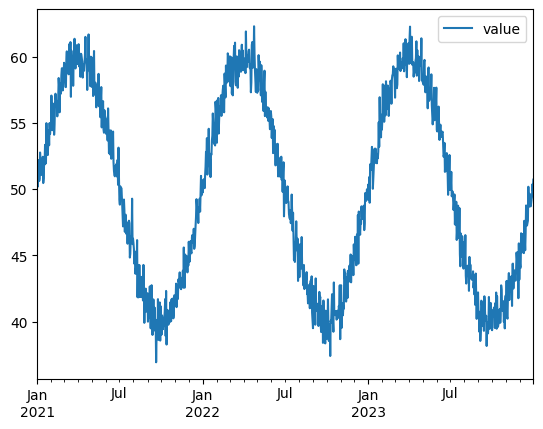

In [ ]:
#| hide
def create_test_data():
    dates = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
    # Create synthetic data with weekly seasonality
    daily_pattern = np.sin(2 * np.pi * dates.day_of_year/ 365) * 10
    values = daily_pattern.to_numpy() + 50  + np.random.normal(0, 1, len(dates))
    return pd.DataFrame(values, index=dates, columns=['value'])

create_test_data().plot()

#### Season data handling

In [ ]:
#| export
class SeasonalityHandler:
    """Class to handle seasonality operations in time series data.
    
    This class provides methods to:
    - Compute seasonal patterns based on week of year
    - Remove seasonality from data
    - Add seasonality back to data
    
    Attributes:
        seasonal_pattern: pd.DataFrame
            The computed seasonal pattern, indexed by week of year
    """
    
    def __init__(self):
        """Initialize the SeasonalityHandler."""
        self.seasonal_pattern = None
    
    def compute_seasonal_pattern(self, data: pd.DataFrame) -> pd.DataFrame:
        """Compute mean values for each week of the year to capture seasonal patterns."""
        if 1 < len(data.columns):
            raise ValueError("Data must contain only one column")
        seasonal_pattern = data.groupby(data.index.isocalendar().week).mean()
        self.seasonal_pattern = seasonal_pattern.rename(columns={data.columns[0]: "season"})
        return self.seasonal_pattern
    
    def remove_seasonality(self, data: pd.DataFrame) -> pd.DataFrame:
        """Remove seasonality from the data."""
        if self.seasonal_pattern is None:
            raise ValueError("Seasonal pattern not computed. Call compute_seasonal_pattern first.")
        
        deseasonalized = data.copy()
        deseasonalized = self._add_week_index(deseasonalized)
        deseasonalized = deseasonalized.join(self.seasonal_pattern, on='week')
        deseasonalized = deseasonalized[data.columns] - deseasonalized["season"].to_numpy().reshape(-1, 1)
        deseasonalized = self._remove_week_index(deseasonalized)
        return deseasonalized
    
    def add_seasonality(self, data: pd.DataFrame) -> pd.DataFrame:
        """Add seasonality back to the data."""
        if self.seasonal_pattern is None:
            raise ValueError("Seasonal pattern not computed. Call compute_seasonal_pattern first.")
        
        reseasonalized = data.copy()
        reseasonalized = self._add_week_index(reseasonalized)
        reseasonalized = reseasonalized.join(self.seasonal_pattern, on='week')
        reseasonalized = reseasonalized[data.columns] + reseasonalized["season"].to_numpy().reshape(-1, 1)
        reseasonalized = self._remove_week_index(reseasonalized)
        
        return reseasonalized
    
    def _add_week_index(self, data: pd.DataFrame) -> pd.DataFrame:
        """Add week as index level to the data."""
        data['week'] = data.index.isocalendar().week
        data.set_index('week', inplace=True, append=True)
        return data
    
    def _remove_week_index(self, data: pd.DataFrame) -> pd.DataFrame:
        """Remove week as index level from the data."""
        data.reset_index(level='week', drop=True, inplace=True)
        return data
    
    def append_season(self, data: pd.DataFrame) -> pd.DataFrame:
        """Append the seasonality to the data."""
        if self.seasonal_pattern is None:
            raise ValueError("Seasonal pattern not computed. Call compute_seasonal_pattern first.")
        joint = data.copy()
        joint = self._add_week_index(joint)
        joint = joint.join(self.seasonal_pattern, on='week')
        joint = self._remove_week_index(joint)
        return joint


First we create an instance:

In [ ]:
seasonality_handler = SeasonalityHandler()

In [ ]:
show_doc(SeasonalityHandler.compute_seasonal_pattern)

---

### SeasonalityHandler.compute_seasonal_pattern

>      SeasonalityHandler.compute_seasonal_pattern
>                                                   (data:pandas.core.frame.Data
>                                                   Frame)

*Compute mean values for each week of the year to capture seasonal patterns.*

Now we compute the seasonality of the data as follows:

In [ ]:
season = seasonality_handler.compute_seasonal_pattern(data)

In [ ]:
#| hide
def test_seasonal_pattern():
    """Test that seasonal pattern computation works correctly"""
    handler = SeasonalityHandler()
    pattern = handler.compute_seasonal_pattern(create_test_data())
    
    if not isinstance(pattern, pd.DataFrame):
        raise ValueError(f"Expected DataFrame but got {type(pattern)}")
    if not len(pattern) == 53:  # Maximum number of weeks in a year
        raise ValueError(f"Expected 53 weeks but got {len(pattern)}")
    if not 'season' in pattern.columns:
        raise ValueError(f"Expected 'season' column but got {pattern.columns}")

def test_multiple_columns():
    """Test that error is raised for multiple columns"""
    handler = SeasonalityHandler()
    data = pd.DataFrame({
        'col1': [1, 2, 3],
        'col2': [4, 5, 6]
    })
    try:
        handler.compute_seasonal_pattern(data)
        raise ValueError("Expected ValueError for multiple columns but none was raised")
    except ValueError as e:
        if str(e) != "Data must contain only one column":
            raise ValueError(f"Wrong error message: {str(e)}")
        
test_seasonal_pattern()
test_multiple_columns()

In [ ]:
show_doc(SeasonalityHandler.remove_seasonality)

---

### SeasonalityHandler.remove_seasonality

>      SeasonalityHandler.remove_seasonality (data:pandas.core.frame.DataFrame)

*Remove seasonality from the data.*

Its also possible to remove the seasonality to our data as follows

<Axes: xlabel='time'>

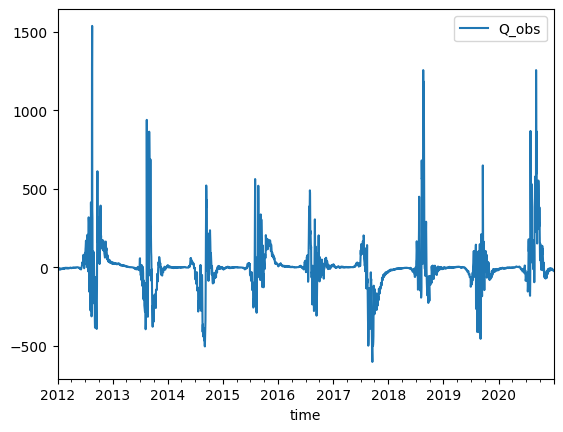

In [ ]:
deseasonalized_data = seasonality_handler.remove_seasonality(data)
deseasonalized_data.plot()

In [ ]:
show_doc(SeasonalityHandler.add_seasonality)

---

### SeasonalityHandler.add_seasonality

>      SeasonalityHandler.add_seasonality (data:pandas.core.frame.DataFrame)

*Add seasonality back to the data.*

We can also add the seasonality back

In [ ]:
seasonality_handler.add_seasonality(deseasonalized_data).head(3)

,Q_obs
time,
2012-01-01,68.839996
2012-01-02,67.500000
2012-01-03,67.349998


In [ ]:
#| hide

def test_seasonality_cycle():
    """Test that removing and adding seasonality returns original data"""
    handler = SeasonalityHandler()
    data = create_test_data()
    handler.compute_seasonal_pattern(data)
    
    deseasonalized = handler.remove_seasonality(data)
    if not deseasonalized.shape == data.shape:
        raise ValueError(f"Shape mismatch after deseasonalization: {deseasonalized.shape} vs {data.shape}")
    
    reseasonalized = handler.add_seasonality(deseasonalized)
    if not reseasonalized.shape == data.shape:
        raise ValueError(f"Shape mismatch after reseasonalization: {reseasonalized.shape} vs {data.shape}")
    
    if not np.allclose(reseasonalized.values, data.values):
        raise ValueError("Values don't match after seasonality cycle")
    
test_seasonality_cycle()


In [ ]:
show_doc(SeasonalityHandler.append_season)

---

### SeasonalityHandler.append_season

>      SeasonalityHandler.append_season (data:pandas.core.frame.DataFrame)

*Append the seasonality to the data.*

Or we can append the seasonal data as a new column as follows

In [ ]:
seasonality_handler.append_season(data).head(3)

,Q_obs,season
time,,
2012-01-01,68.839996,90.025156
2012-01-02,67.500000,79.543198
2012-01-03,67.349998,79.543198


In [ ]:
#| hide
def test_append_season():
    """Test that appending seasonal component works correctly"""
    handler = SeasonalityHandler()
    data = create_test_data()
    handler.compute_seasonal_pattern(data)
    
    result = handler.append_season(data)
    if not result.shape[1] == data.shape[1] + 1:
        raise ValueError(f"Expected {data.shape[1] + 1} columns but got {result.shape[1]}")
    if not 'season' in result.columns:
        raise ValueError("'season' column not found in result")
    
test_append_season()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()